In [1]:
import os
from tqdm.auto import tqdm
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from utils.dist_utils import quantiles_to_pdf_kde


from utils.data_utils import get_dataset, DynamicBatchSampler, collate_fn, get_static_dataset, get_test_dataset, get_grouping, get_test_synthetic_dataset
from utils.optuna_utils import load_best_model
from utils.train_utils import TwoStageQuantileLoss, ComparisonQuantileLoss
from LSTM import train

quantiles = [
        0.00005, 0.00025, 0.00075, 0.00125, 0.00175, 0.0025, 0.005, 0.01, 0.015, 0.02, 0.03,
        0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7,
        0.75, 0.8, 0.85, 0.9, 0.95, 0.98, 0.99, 0.995, 0.9975, 0.99925, 0.99975, 0.99995
    ]
loss_fn = TwoStageQuantileLoss(quantiles)
test_loss_fn = ComparisonQuantileLoss(quantiles)
results = {}


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore")

In [2]:
lstm_model, lstm_params = load_best_model('lstm')

lstm_model.to(DEVICE)

lstm_normalazation_window = lstm_params['normalazation_window']
lstm_batch_size = lstm_params['batch_size']
l1_reg = lstm_params['l1_reg']
l2_reg = lstm_params['l2_reg']

lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lstm_params['learning_rate'], weight_decay=l2_reg)

print(lstm_model)
print(f"Model has {sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)} parameters")

LSTM_Model(
  (normalize_lstm): LSTM(49, 64, num_layers=2, batch_first=True, dropout=0.23715026182885748)
  (normalize_module): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): Dropout(p=0.23715026182885748, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (5): Dropout(p=0.23715026182885748, inplace=False)
    (6): Linear(in_features=256, out_features=37, bias=True)
  )
  (market_lstm): LSTM(21, 128, num_layers=3, batch_first=True, dropout=0.23715026182885748)
  (market_module): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
    (3): Dropout(p=0.23715026182885748, inplace=False)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
Model has 489638 parameters


In [3]:
lstm_params

{'batch_size': 256,
 'learning_rate': 0.0006214962301278183,
 'normalazation_window': 21,
 'raw_lstm_layers': 2,
 'raw_lstm_h': 64,
 'raw_hidden_layers': 2,
 'raw_hidden_layer_0': 128,
 'raw_hidden_layer_1': 256,
 'market_lstm_layers': 3,
 'market_lstm_h': 128,
 'market_hidden_layers': 1,
 'market_hidden_layer_0': 256,
 'dropout': 0.23715026182885748,
 'market_activation': 'tanh',
 'hidden_activation': '',
 'use_layer_norm': 1,
 'l1_reg': 0.000647713575177285,
 'l2_reg': 0.0002983277631742518}

In [4]:
if os.path.exists('lstm_model.pth'):
    lstm_model.load_state_dict(torch.load('lstm_model.pth'))
    lstm_model.to(DEVICE)
    print("Model loaded from lstm_model.pth")
else:
    lstm_train_dataset = get_dataset(
    lstm_normalazation_window, "1998-01-01", "2018-01-01")
    lstm_val_dataset = get_dataset(lstm_normalazation_window, "2018-01-01", "2019-01-01")
    lstm_train_batch_sampler = DynamicBatchSampler(
        lstm_train_dataset, batch_size=lstm_batch_size)
    lstm_val_batch_sampler = DynamicBatchSampler(lstm_val_dataset, batch_size=lstm_batch_size)


    lstm_train_loader = DataLoader(
        lstm_train_dataset, batch_sampler=lstm_train_batch_sampler, collate_fn=collate_fn)
    lstm_val_loader = DataLoader(
        lstm_val_dataset, batch_sampler=lstm_val_batch_sampler, collate_fn=collate_fn)
    _, lstm_model = train(
        model=lstm_model,
        train_loader=lstm_train_loader,
        val_loader=lstm_val_loader,
        criterion=loss_fn,
        optimizer=lstm_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(lstm_model.state_dict(), 'lstm_model.pth')


Model loaded from lstm_model.pth


/tmp/ipykernel_1235/2344815876.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_model.load_state_dict(torch.load('lstm_model.pth'))


In [5]:
dense_model, dense_params = load_best_model('dense')

dense_model.to(DEVICE)

dense_normalazation_window = dense_params['normalazation_window']
dense_batch_size = dense_params['batch_size']
l1_reg = dense_params['l1_reg']
l2_reg = dense_params['l2_reg']

dense_optimizer = torch.optim.Adam(dense_model.parameters(), lr=dense_params['learning_rate'], weight_decay=l2_reg)

print(dense_model)

QuantileDense(
  (raw_layers): ModuleList(
    (0): Linear(in_features=49, out_features=256, bias=True)
    (1): Dropout(p=0.029313152060112584, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.029313152060112584, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): Dropout(p=0.029313152060112584, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=64, bias=True)
    (10): Dropout(p=0.029313152060112584, inplace=False)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=512, bias=True)
    (13): Dropout(p=0.029313152060112584, inplace=False)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=37, bias=True)
  )
  (raw_model): Sequential(
    (0): Linear(in_features=49, out_features=256, bias=True)
    (1): Dropout(p=0.029313152060112584, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)

In [6]:
dense_params

{'batch_size': 2048,
 'learning_rate': 0.000994685096139014,
 'normalazation_window': 228,
 'n_raw_hidden_layers': 5,
 'raw_hidden_layer_0': 256,
 'raw_hidden_layer_1': 128,
 'raw_hidden_layer_2': 32,
 'raw_hidden_layer_3': 64,
 'raw_hidden_layer_4': 512,
 'hidden_activation': 'relu',
 'n_market_hidden_layers': 3,
 'market_hidden_layer_0': 512,
 'market_hidden_layer_1': 64,
 'market_hidden_layer_2': 128,
 'market_activation': 'tanh',
 'dropout': 0.029313152060112584,
 'layer_norm': 0,
 'l1_reg': 0.00018615663038372592,
 'l2_reg': 0.0005702296705806681}

In [7]:
if os.path.exists('dense_model.pth'):
    dense_model.load_state_dict(torch.load('dense_model.pth'))
    dense_model.to(DEVICE)
    print("Model loaded from dense_model.pth")
else:
    dense_train_dataset = get_static_dataset(dense_normalazation_window, "1998-01-01", "2018-01-01")
    dense_val_dataset = get_static_dataset(dense_normalazation_window, "2018-01-01", "2019-01-01")

    dense_train_loader = DataLoader(dense_train_dataset, batch_size=dense_batch_size, shuffle=True)
    dense_val_loader = DataLoader(dense_val_dataset, batch_size=dense_batch_size, shuffle=False)
    _, dense_model = train(
        model=dense_model,
        train_loader=dense_train_loader,
        val_loader=dense_val_loader,
        criterion=loss_fn,
        optimizer=dense_optimizer,
        num_epochs=100,
        patience=10,
        l1_reg=l1_reg,
        verbose=True
    )
    torch.save(dense_model.state_dict(), 'dense_model.pth')

Model loaded from dense_model.pth


/tmp/ipykernel_1235/2142353267.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dense_model.load_state_dict(torch.load('dense_model.pth'))


In [8]:
dense_test_dataset = get_test_dataset(dense_normalazation_window, "2019-01-01", "2024-01-01")
lstm_test_dataset = get_test_dataset(lstm_normalazation_window, "2019-01-01", "2024-01-01")

In [9]:
def infrence(model, dataloader, is_dense=True):
    losses = []
    targets = []
    model.eval()
    for x, s, z, y, _ in dataloader:
        x, s, z, y = x.to(DEVICE), s.to(DEVICE), z.to(DEVICE), y.to(DEVICE)
        if is_dense:
            x = x[:, 0, :]
            z = z[:, 0, :]
            s = s[:, 0]
        else:
            s = s.mean(dim=1)
        with torch.no_grad():
            _, y_pred = model(x, s, z)
            loss = test_loss_fn(y_pred, y[:, -1])
            losses.extend(loss.cpu().numpy())
            targets.extend(y[:, -1].cpu().numpy())
    losses = torch.tensor(losses)
    targets = torch.tensor(targets)

    return losses

In [10]:
assets = dense_test_dataset.assets
datas = dense_test_dataset.datas

In [ ]:
batch_size = 1024
for asset in tqdm(assets, desc='Inferencing models'):
    grouping = get_grouping(datas, asset)
    if grouping not in results:
        results[grouping] = {
            'dense': 0,
            'lstm': 0
        }
    dense_test_dataset.set_main_asset(asset)
    lstm_test_dataset.set_main_asset(asset)
    
    dense_data_loader = DataLoader(dense_test_dataset, batch_size=1024, shuffle=False)
    lstm_data_loader = DataLoader(lstm_test_dataset, batch_size=1024, shuffle=False)
    dense_losses = infrence(dense_model, dense_data_loader, is_dense=True)
    lstm_losses = infrence(lstm_model, lstm_data_loader, is_dense=False)
    results[grouping]['dense'] += dense_losses.mean().item()
    results[grouping]['lstm'] += lstm_losses.mean().item()

In [ ]:
results = {k: {model: value / 10 for model, value in v.items()} for k, v in results.items()}

# Create DataFrame
df = pd.DataFrame(results).T

# Calculate total mean
dense_total_mean = df['dense'].mean()
lstm_total_mean = df['lstm'].mean()
new_row = pd.DataFrame({'dense': dense_total_mean, 'lstm': lstm_total_mean}, index=['Total Mean'])
df = pd.concat([df, new_row])

# Calculate difference
df['Difference (Dense - LSTM)'] = df['dense'] - df['lstm']

# Format the table
formatted_df = df.apply(lambda x: round(x, 4))

print(formatted_df.to_string())

In [24]:
def plot_pdf_cdf(asset, dense_test_dataset, lstm_test_dataset):
    idx = np.random.randint(0, len(dense_test_dataset))
    dense_test_dataset.set_main_asset(asset)
    lstm_test_dataset.set_main_asset(asset)

    dense_input = dense_test_dataset[idx]
    x, s, z, _, _ = dense_input
    x = x.to(DEVICE)[0].view(1, -1)
    s = s.to(DEVICE)[0].view(1, -1)
    z = z.to(DEVICE)[0].view(1, -1)
    dense_model.eval()
    _, dense_quantiles = dense_model(x, s, z)
    dense_quantiles = dense_quantiles.detach().cpu().numpy().flatten()

    lstm_input = lstm_test_dataset[idx]
    lstm_model.eval()
    x, s, z, y, _ = lstm_input
    x = x.to(DEVICE).view(1, x.shape[0], -1)
    s = s.to(DEVICE).mean().view(1, -1)
    z = z.to(DEVICE).view(1, z.shape[0], -1)
    _, lstm_quantiles = lstm_model(x, s, z)
    lstm_quantiles = lstm_quantiles.detach().cpu().numpy().flatten()

    dense_pdf, dense_cdf, dense_grid = quantiles_to_pdf_kde(dense_quantiles/100)
    lstm_pdf, lstm_cdf, lstm_grid = quantiles_to_pdf_kde(lstm_quantiles/100)

    plt.figure(figsize=(12, 10))
    plt.suptitle(f'PDF and CDF of {asset}\'s Log Return', fontsize=16)

    # Dense PDF
    plt.subplot(2, 2, 1)
    plt.plot(dense_grid, dense_pdf, label="Dense PDF", color="blue", linestyle='-')
    plt.fill_between(dense_grid.flatten(), dense_pdf, color="lightblue", alpha=0.5)
    plt.title("Dense PDF", fontsize=14)
    plt.xlabel("Log Return", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)

    # LSTM PDF
    plt.subplot(2, 2, 2)
    plt.plot(lstm_grid, lstm_pdf, label="LSTM PDF", color="red", linestyle='-')
    plt.fill_between(lstm_grid.flatten(), lstm_pdf, color="pink", alpha=0.5)
    plt.title("LSTM PDF", fontsize=14)
    plt.xlabel("Log Return", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.legend(loc="upper right", fontsize=10)

    # Dense CDF
    plt.subplot(2, 2, 3)
    plt.plot(dense_grid, dense_cdf, label="Dense CDF", color="blue", linestyle='--')
    plt.title("Dense CDF", fontsize=14)
    plt.xlabel("Log Return", fontsize=12)
    plt.ylabel("Cumulative Probability", fontsize=12)
    plt.legend(loc="upper left", fontsize=10)

    # LSTM CDF
    plt.subplot(2, 2, 4)
    plt.plot(lstm_grid, lstm_cdf, label="LSTM CDF", color="orange", linestyle='--')
    plt.title("LSTM CDF", fontsize=14)
    plt.xlabel("Log Return", fontsize=12)
    plt.ylabel("Cumulative Probability", fontsize=12)
    plt.legend(loc="upper left", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to leave space for the main title
    plt.show()


/mnt/c/Users/izzak/Dropbox/Articles/Dist-pred/Code/utils/data_utils.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = torch.tensor(self.s[idx], dtype=torch.float32).to(


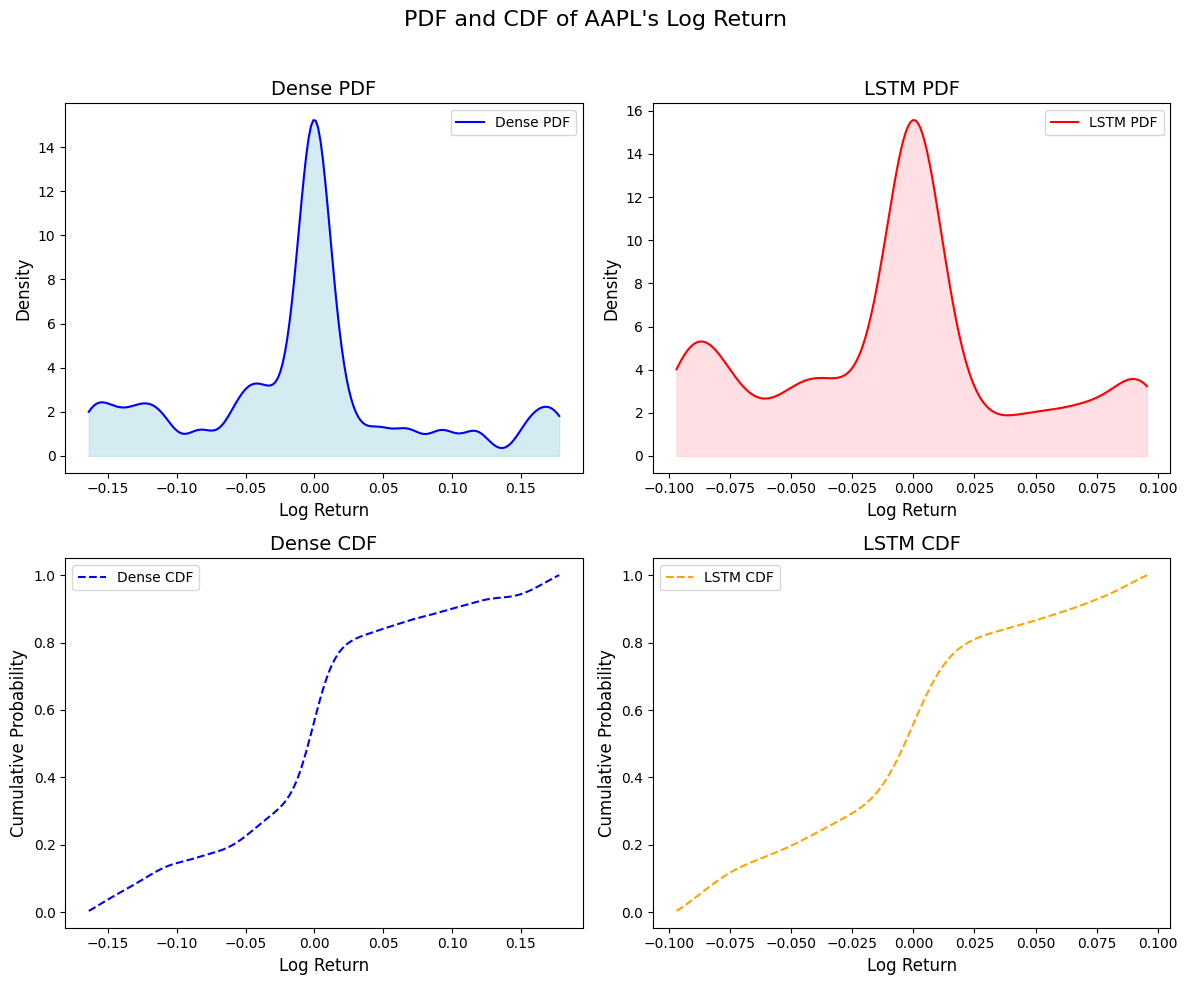

In [25]:
plot_pdf_cdf('AAPL', dense_test_dataset, lstm_test_dataset)

In [26]:
dense_synthetic_test_dataset, lstm_synthetic_test_dataset = get_test_synthetic_dataset(dense_normalazation_window, lstm_normalazation_window, 1000, 0.7)

Generated mu: 0.000395, sigma: 0.021023
Generated mu: 0.000339, sigma: 0.012679
Generated mu: -0.000492, sigma: 0.010053
Generated mu: 0.000582, sigma: 0.019088
Generated mu: 0.000369, sigma: 0.025793
Generated mu: 0.000238, sigma: 0.027620
Generated mu: 0.000982, sigma: 0.022125
Generated mu: -0.000424, sigma: 0.029334
Generated mu: -0.000025, sigma: 0.022853
Generated mu: -0.000927, sigma: 0.029526
Asset 1 correlation with market data: 0.5184
Asset 2 correlation with market data: 0.5077
Asset 3 correlation with market data: 0.5001
Asset 4 correlation with market data: 0.5078
Asset 5 correlation with market data: 0.5111
Asset 6 correlation with market data: 0.5070
Asset 7 correlation with market data: 0.5011
Asset 8 correlation with market data: 0.5142
Asset 9 correlation with market data: 0.4846
Asset 10 correlation with market data: 0.5134


In [27]:
dense_total_loss = 0
lstm_total_loss = 0
for i in range(0, 10):
    dense_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
    lstm_synthetic_test_dataset.set_main_asset(f"synthetic_{i}")
    dense_data_loader = DataLoader(dense_synthetic_test_dataset, batch_size=1024, shuffle=False)
    lstm_data_loader = DataLoader(lstm_synthetic_test_dataset, batch_size=1024, shuffle=False)
    dense_losses = infrence(dense_model, dense_data_loader, is_dense=True)
    lstm_losses = infrence(lstm_model, lstm_data_loader, is_dense=False)
    dense_total_loss += dense_losses.mean().item()
    lstm_total_loss += lstm_losses.mean().item()

dense_total_loss /= 10
lstm_total_loss /= 10

results["synthetic"] = {
    'dense': dense_total_loss,
    'lstm': lstm_total_loss
}

/mnt/c/Users/izzak/Dropbox/Articles/Dist-pred/Code/utils/data_utils.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = torch.tensor(self.s[idx], dtype=torch.float32).to(
/tmp/ipykernel_1235/1681797752.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  losses = torch.tensor(losses)
/mnt/c/Users/izzak/Dropbox/Articles/Dist-pred/Code/utils/data_utils.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

In [28]:
# Create DataFrame
df = pd.DataFrame(results).T

# Calculate total mean
dense_total_mean = df['dense'].mean()
lstm_total_mean = df['lstm'].mean()
new_row = pd.DataFrame({'dense': dense_total_mean, 'lstm': lstm_total_mean}, index=['Total Mean'])
df = pd.concat([df, new_row])

# Calculate difference
df['Difference (Dense - LSTM)'] = df['dense'] - df['lstm']

# Format the table
formatted_df = df.apply(lambda x: round(x, 4))

print(formatted_df.to_string())

             dense    lstm  Difference (Dense - LSTM)
synthetic   0.8809  0.5423                     0.3386
Total Mean  0.8809  0.5423                     0.3386


/mnt/c/Users/izzak/Dropbox/Articles/Dist-pred/Code/utils/data_utils.py:327: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  s = torch.tensor(self.s[idx], dtype=torch.float32).to(


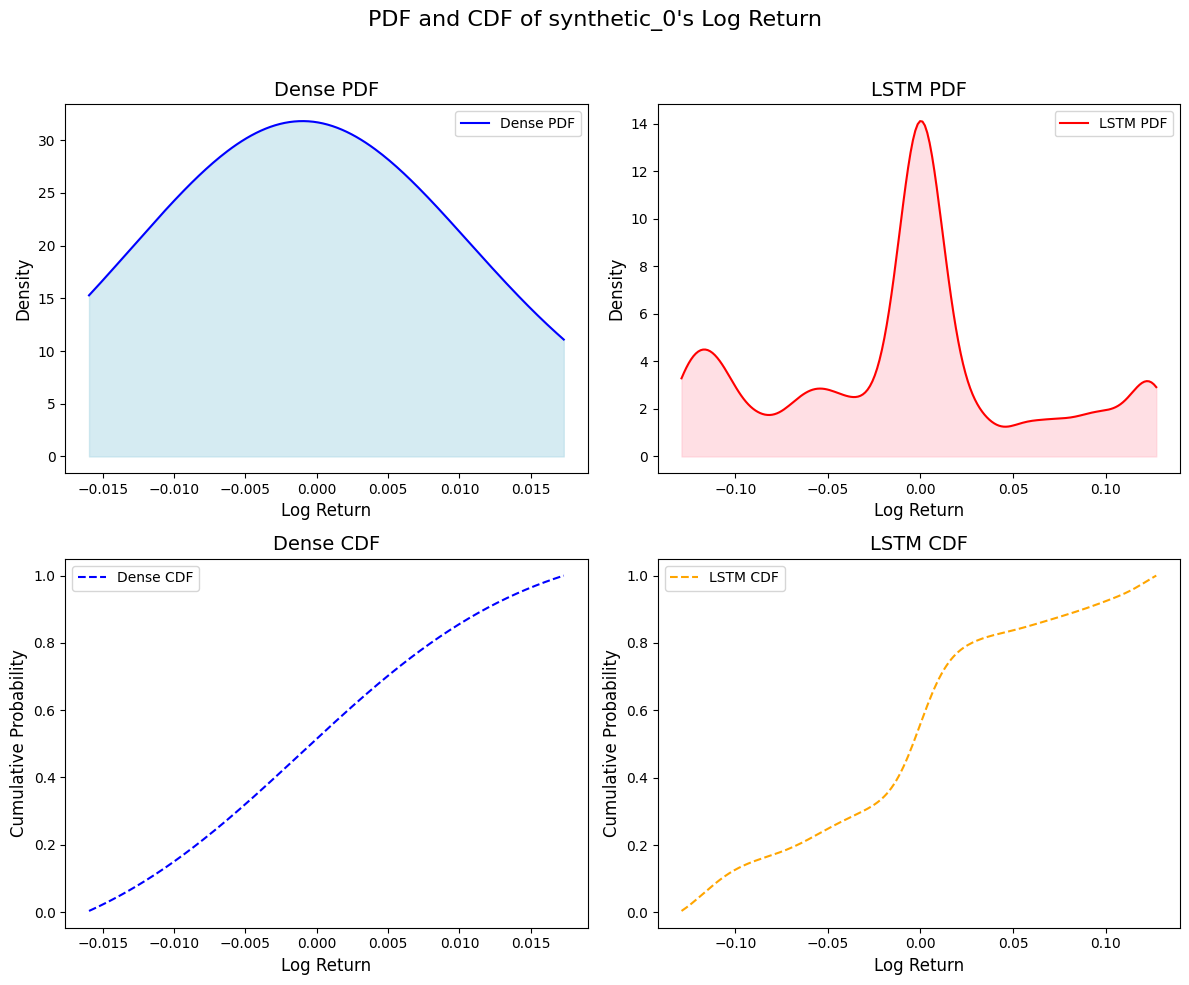

In [30]:
plot_pdf_cdf('synthetic_0', dense_synthetic_test_dataset, lstm_synthetic_test_dataset)